# Pandas DataFrame as a Database

This script creates a single dataframe containing AFU data for every structure in all experiments. 

Columns define group, drug, distance, structure, etc.

This large dataframe can be queried as needed, or exported as a CSV.

In [5]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

database = pd.DataFrame(columns = ['Group', 'Distance', 'MCN', 'Sniffer', 'AFU'])

def addGroup(folderPath, groupName):    
    filePaths = glob.glob(folderPath+"/*.xls")
    filePaths = [x for x in filePaths if not "bleachCorrected" in x]
    filePaths = [x for x in filePaths if x.endswith("um.xls")]
    for filePath in filePaths:
        fileName = os.path.basename(filePath)
        distance = int(fileName.replace("um.xls", ""))
        addExperiment(filePath, groupName, distance)

def addExperiment(filePath, groupName, distance):
    global database
    df = pd.read_csv(filePath, delimiter="\t")
    roiNames = df.columns[1:]
    for roiName in roiNames:
        mcn, distance, sniffer = roiName.split(".")
        distance = int(distance.replace("um", ""))
        afu = df[roiName].values
        row = {'Group': groupName, 'Distance': distance, 'MCN': mcn, 'Sniffer':sniffer, 'AFU':afu}
        database = database.append(row,ignore_index = True)
        
addGroup(R"X:\Data\OT-Cre\OT-GCaMP-nonspecific\04-03-19 evoke OT\04-30-2020 Cs-GLU analyze", "CsGlu")
addGroup(R"X:\Data\OT-Cre\OT-GCaMP-nonspecific\04-03-19 evoke OT\04-30-2020 K-GLU analyze", "KGlu")
addGroup(R"X:\Data\OT-Cre\OT-GCaMP-nonspecific\04-03-19 evoke OT\04-30-2020 L368 - Cs analyze", "L368")

database

,Group,Distance,MCN,Sniffer,AFU
0,CsGlu,25,19514000,C1,"[1286.65983, 1266.2571699999999, 1189.49916999..."
1,CsGlu,25,19514000,C2,"[2948.64467, 2962.93833, 3239.71167, 3417.8625..."
2,CsGlu,25,19514000,C3,"[5736.4195, 5736.50717, 5026.41233, 4580.00867..."
3,CsGlu,25,19514000,C4,"[2283.93833, 2211.74517, 2253.62167, 2301.0938..."
4,CsGlu,25,19514000,C5,"[2045.98417, 1792.38467, 2021.4029999999998, 1..."
...,...,...,...,...,...
441,L368,125,20217028,C15,"[1024.454, 1141.7939999999999, 1079.1860000000..."
442,L368,125,20217028,C16,"[1149.15, 1137.655, 1136.93, 1116.005, 1118.42..."
443,L368,125,20217028,C17,"[3113.2129999999997, 2974.022, 3031.2940000000..."
444,L368,125,20217028,C18,"[1648.366, 1611.486, 1646.211, 1597.274, 1576...."


## Query the Data

In [2]:
# show ROI data for every combination

distances = [25, 50, 75, 100, 125]
groups = ["CsGlu", "KGlu", "L368"]

for group in groups:
    for distance in distances:
        rows = database.loc[(database['Group'] == group) & (database['Distance'] == distance)]
        afus = rows['AFU'].values
        print(group, distance, f"({len(afus)} ROI curves)")

CsGlu 25 (80 ROI curves)
CsGlu 50 (48 ROI curves)
CsGlu 75 (28 ROI curves)
CsGlu 100 (27 ROI curves)
CsGlu 125 (15 ROI curves)
KGlu 25 (62 ROI curves)
KGlu 50 (30 ROI curves)
KGlu 75 (32 ROI curves)
KGlu 100 (16 ROI curves)
KGlu 125 (20 ROI curves)
L368 25 (26 ROI curves)
L368 50 (20 ROI curves)
L368 75 (10 ROI curves)
L368 100 (13 ROI curves)
L368 125 (19 ROI curves)


## Analyze the Data

We probably don't need all the raw curves. We can just analyze the raw curves and replace them with the analyzed value. In this example it's just mean, but it could probably be something like "peak slope".

In [10]:
analyzed = database.copy()
analyzed["Responsiveness"] = [x.mean() for x in analyzed["AFU"].values]
analyzed = analyzed.drop(columns=["AFU"])

# optionally you can save these results to easily load into Origin or Excel
#analyzed.to_csv("analyzed.csv")
analyzed

,Group,Distance,MCN,Sniffer,Responsiveness
0,CsGlu,25,19514000,C1,1078.670748
1,CsGlu,25,19514000,C2,3168.950441
2,CsGlu,25,19514000,C3,5389.776329
3,CsGlu,25,19514000,C4,1891.999812
4,CsGlu,25,19514000,C5,1712.651183
...,...,...,...,...,...
441,L368,125,20217028,C15,991.347644
442,L368,125,20217028,C16,1025.389658
443,L368,125,20217028,C17,2257.949260
444,L368,125,20217028,C18,1452.787534


## Plot by Group

Since the data is already analyzed in a dataframe, it's now easy to plot it.

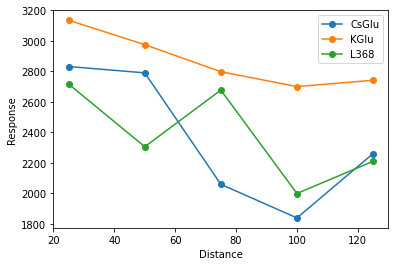

In [4]:
distances = [25, 50, 75, 100, 125]
groups = ["CsGlu", "KGlu", "L368"]

for group in groups:
    responseByDistance = []
    for distance in distances:
        rows = analyzed.loc[(database['Group'] == group) & (database['Distance'] == distance)]
        responseByDistance.append(rows['Responsiveness'].values.mean())
    plt.plot(distances, responseByDistance, 'o-', label=group)

plt.legend()
plt.ylabel("Response")
plt.xlabel("Distance")
plt.show()